## Sensoriamento Remoto com GRASS-GIS

### 2 - Change Detection + classificação

#### jupyter-notebook por Carlos H. Grohmann (Guâno)

In [1]:
# imports
import sys, os, itertools
import numpy as np
import pandas as pd
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

%matplotlib inline

In [2]:
# requires version 7.8+
# create GRASS GIS runtime environment

# definir o caminho do executável do GRASS, Aqui está para uma máquina Linux
# as duas formas abaixo retornam o mesmo resultado
gisbase = subprocess.check_output(["/usr/local/grass/bin/grass", "--config", "path"]).strip().decode() 
# gisbase = subprocess.check_output(["/usr/local/grass/bin/grass", "--config", "path"], text=True).strip() 

os.environ['GISBASE'] = gisbase
sys.path.append(os.path.join(gisbase, "etc", "python"))

# GRASS GIS imports
import grass.script as grass # este traz os módulos do GRASS
import grass.script.setup as gsetup
import grass.script.array as garray # este é para trabalhar com rasters como matrizes do numpy
# import grass.script.vector as gvect # este é para trablahar com vetores
import grass.jupyter as gj # este é para fazer o display dos mapas no notebook jupyter

# check GRASS version
print(gisbase)

/usr/local/grass/grass80


In [3]:
# set GRASS GIS session data

# aqui definimos o caminho da nossa Location/Mapset. Definir de acordo com o próprio sistema
# rcfile = gsetup.init(gisbase, "/mnt/d/grassdata/", "curso_yt_utm", "yt22")
rcfile = gsetup.init(gisbase, "/home/guano/HDD/grassdata/", "curso_yt_utm", "yt22")

grass.message('Current GRASS GIS 7 environment:')
print (grass.gisenv())

{'GISDBASE': '/home/guano/HDD/grassdata/', 'LOCATION_NAME': 'curso_yt_utm', 'MAPSET': 'yt22'}


In [4]:
# define region - TODA A ÁREA DA CENA
n = 7390000
s = 7175000
w = 639000
e = 880000
res = 30
grass.run_command('g.region', flags='pa', s=s, n=n, w=w, e=e, res=res)

In [5]:
# check region
grass.parse_command('g.region', flags='pg')

{'projection': '1',
 'zone': '-22',
 'n': '7390020',
 's': '7174980',
 'w': '639000',
 'e': '880020',
 'nsres': '30',
 'ewres': '30',
 'rows': '7168',
 'cols': '8034',
 'cells': '57587712'}

In [6]:
# set data dir
# datadir = '/mnt/d/geodata/landsat/petar/'
datadir = '/home/guano/HDD/geodata/landsat/petar/'
srtmdir = '/home/guano/HDD/geodata/srtm/'
mbdir = '/home/guano/HDD/geodata/mbiomas/'

# essas são as imagens collection 2 que trabalhamos no outro notebook
l7c2 = 'l7c2'

# estas são as imagens mais recentes, que precisamos importar, etc
l8c2 = 'l8c2'
l8c2_dir = 'LC08_L2SP_220077_20191027_20200825_02_T1'
l8c2_basefilename = 'LC08_L2SP_220077_20191027_20200825_02_T1_SR_B'

# mapbiomas
mb_atlant = 'COLECAO_5_DOWNLOADS_COLECOES_ANUAL_MATAATLANTICA_MATAATLANTICA-2009.tif'
mb_cerrad = 'COLECAO_5_DOWNLOADS_COLECOES_ANUAL_CERRADO_CERRADO-2009.tif'
mbiomas = 'mbiomas'

### Importar imagens Landsat 8 Collection 2

In [53]:
# L8, col2
# landsat 8 tem a banda 1 do costeiro
for band in [1,2,3,4,5,6,7]:
    tif = f'{datadir}{l8c2_dir}/{l8c2_basefilename}{band}.TIF'
    imp = f'{l8c2}_B.{band}'
    grass.run_command('r.import', input=tif, output=imp, extent='region', overwrite=True)

#### Scale factor + offset - collection 2 
https://www.usgs.gov/faqs/how-do-i-use-a-scale-factor-landsat-level-2-science-products?qt-news_science_products=0#qt-news_science_products

In [55]:
# scale factor and offset (VNIR, SWIR)
sfactor = 0.0000275
offset = -0.2

In [56]:
# L8, col2
for band in [1,2,3,4,5,6,7]:
    r_in = f'{l8c2}_B.{band}'
    r_out = f'{l8c2}_SR_B.{band}'
    grass.mapcalc(f'{r_out} = ({r_in}*{sfactor}) + {offset}', overwrite=True)
    grass.run_command('r.null', map=r_out, setnull='1.01-500')  
    grass.run_command('r.colors', map=r_out, color='grey')

In [57]:
# L8 col2 - enhance colors
img = f'{l8c2}_SR_B.'

(r,g,b) = (1,2,3)
grass.run_command('i.colors.enhance', red=f'{img}{r}', green=f'{img}{g}', blue=f'{img}{b}', strength=99)

(r,g,b) = (4,5,7)
grass.run_command('i.colors.enhance', red=f'{img}{r}', green=f'{img}{g}', blue=f'{img}{b}', strength=99)

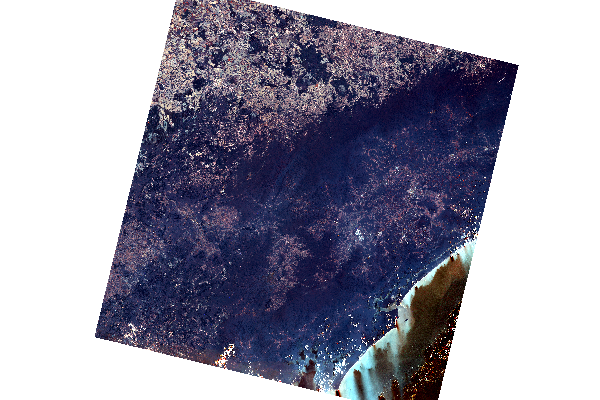

In [7]:
# display
r = f'{l8c2}_SR_B.4'
g = f'{l8c2}_SR_B.3'
b = f'{l8c2}_SR_B.2' 

img = gj.GrassRenderer()
img.run('d.rgb', red=r, green=g, blue=b)
img.show()

### Importar tifs Mapbiomas
#### dados mapbiomas baixados daqui:
https://mapbiomas.org/colecoes-mapbiomas-1?cama_set_language=pt-BR

In [14]:
# mata atlantica
tif = f'{mbdir}{mb_atlant}'
imp_ma = 'mbiomas_MAt'
grass.run_command('r.import', input=tif, output=imp_ma, extent='region', overwrite=True)

In [15]:
# cerrado
tif = f'{mbdir}{mb_cerrad}'
imp_cr = 'mbiomas_Cerr'
grass.run_command('r.import', input=tif, output=imp_cr, extent='region', overwrite=True)

In [16]:
# definir zero como nulo
grass.run_command('r.null', map=imp_ma, setnull='0')
grass.run_command('r.null', map=imp_cr, setnull='0')

In [17]:
# juntar em 1 mapa só
grass.run_command('r.patch', input=[imp_ma,imp_cr], output='mbiomas', overwrite=True)

In [25]:
# escala de cores Mapbiomas
# https://stackoverflow.com/questions/29643352/converting-hex-to-rgb-value-in-python

# def hex_to_rgb(value):
#     value = value.lstrip('#')
#     lv = len(value)
#     return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

# def rgb_to_hex(rgb):
#     return '#%02x%02x%02x' % rgb

# c_hex = ['#006400','#00ff00','#687537','#935132','#45c2a5','#b8af4f','#f1c232','#ffd966','#c27ba0','#fff3bf','#dd7e6b','#aa0000','#ff0000','#d5d5e5','#b2ae7c','#af2a2a','#8a2be2','#0000ff','#968c46','#c59ff4','#e787f8','#f3b4f1']
# c_rgb = [hex_to_rgb(i) for i in c_hex]

c_rgb = ['3 0:100:0','4 0:255:0','5 104:117:55','9 147:81:50','11 69:194:165','12 184:175:79','13 241:194:50','15 255:217:102','20 194:123:160','21 255:243:191','23 221:126:107','24 170:0:0','25 255:0:0','27 213:213:229','29 178:174:124','30 175:42:42','31 138:43:226','33 0:0:255','34 150:140:70','39 197:159:244','41 231:135:248','36 243:180:241']

colr_mbiom = "\n".join(c_rgb)

In [19]:
# set colors
grass.write_command('r.colors', map='mbiomas', rules='-', stdin=colr_mbiom);

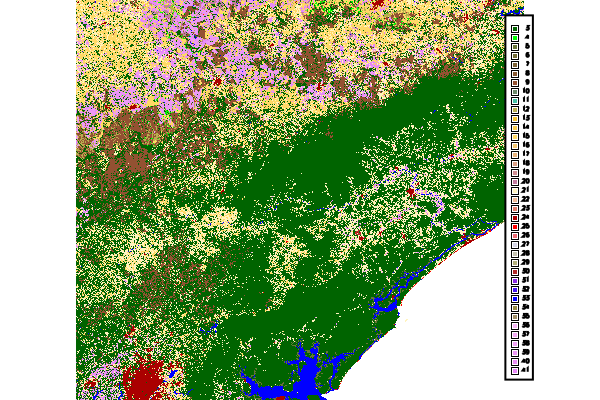

In [20]:
# mostrar mapas
rast = 'mbiomas'
img = gj.GrassRenderer()
img.run('d.rast', map=rast) 
img.run('d.legend',raster=rast, at=(5, 95, 85, 90), flags="b")
img.show()

### Change Detection + Tasseled cap transformation

Tasseled cap transformation  
https://veroandreo.gitlab.io/post/jan2021_ilandsat_tutorial/  
https://grass.osgeo.org/grass78/manuals/i.tasscap.html

In [13]:
# l7, c2 (1999)
ls_pre = [f'{l7c2}_SR_B.{band}' for band in [1,2,3,4,5,7]]
tc_pre = f'{l7c2}_SR_TC'
sens_pre = 'landsat7_etm'

In [ ]:
grass.run_command('i.tasscap', input=ls_pre, output=tc_pre, sensor=sens_pre, overwrite=True)

In [14]:
# l8, c2 (2019)
ls_post = [f'{l8c2}_SR_B.{band}' for band in [2,3,4,5,6,7]]
tc_post = f'{l8c2}_SR_TC'
sens_post = 'landsat8_oli'

In [ ]:
grass.run_command('i.tasscap', input=ls_post, output=tc_post, sensor=sens_post, overwrite=True)

Change vector analysis (addon)  
https://grass.osgeo.org/grass78/manuals/addons/i.cva.html

In [45]:
# instalação
# grass.run_command('g.extension', extension='i.cva')

In [17]:
xa = f'{tc_pre}.1'
xb = f'{tc_post}.1'
ya = f'{tc_pre}.2'
yb = f'{tc_post}.2'
out_cva = f'CVA_pre_post'
cva_change = f'{out_cva}_change'

In [47]:
grass.run_command('i.cva', xaraster=xa, xbraster=xb, yaraster=ya, ybraster=yb, 
                  output=out_cva, stat_threshold=1, overwrite=True)

In [18]:
# from i.cva man page
# assign legend
i_cva_leg_rules = ['1:moisture reduction', '2:chlorophyll increase', '3:moisture increase', '4:bare soil increase']
i_cva_legend = '\n'.join(i_cva_leg_rules)
grass.write_command('r.category', map=cva_change, separator=':', rules='-', stdin=i_cva_legend)

0

In [19]:
# assign colors
i_cva_col_rules = ['1 217:255:0', '2 10:214:10', '3 75:173:255', '4 139:105:20']
i_cva_colors = '\n'.join(i_cva_col_rules)
grass.write_command('r.colors', map=cva_change, rules='-', stdin=i_cva_colors);

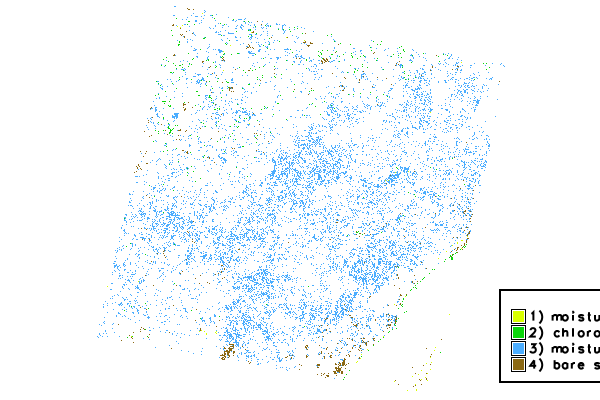

In [22]:
# display
rast = f'{out_cva}_change'
img = gj.GrassRenderer()
img.run('d.rast', map=rast) 
img.run('d.legend',raster=rast, at=(5, 25, 85, 90), flags="b")
img.show()

### Classificação não-supervisionada (imagem 1999)

In [31]:
nclasses = 5

In [32]:
# nome para gupo e subgrupo de imagens
g_sg = l7c2
img_list = [f'{l7c2}_SR_B.{band}' for band in [1,2,3,4,5,7]]
img_class = f'{l7c2}_SR_classified_n{nclasses}'
img_rejec = f'{l7c2}_SR_rejected_n{nclasses}'
sigfile = f'{g_sg}_sigfile.txt'

In [33]:
# 1 - gerar grupo de imagens
grass.run_command('i.group', group=g_sg, subgroup=g_sg, input=img_list, overwrite=True)

In [34]:
# 2 - gerar clusters automáticos - não é preciso definir caminho do arquivo vai para location/mapset
grass.run_command('i.cluster', group=g_sg, subgroup=g_sg, signaturefile=sigfile, classes=nclasses, overwrite=True)

In [35]:
# 3 - rodar classificação
grass.run_command('i.maxlik', group=g_sg, subgroup=g_sg, signaturefile=sigfile, output=img_class, reject=img_rejec, overwrite=True)

In [36]:
# 4 - set color table
grass.run_command('r.colors', map=img_class, color='byr')

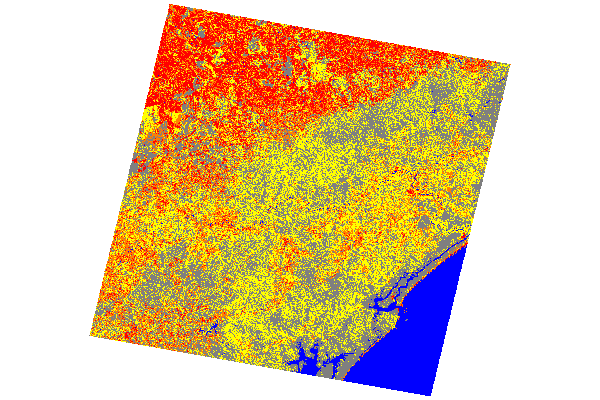

In [37]:
# 5 - display
rast = img_class
img = gj.GrassRenderer()
img.run('d.rast', map=rast) 
# img.run('d.legend',raster=rast, at=(5, 95, 85, 90), flags="b")
img.show()

### Classificação supervisionada com Random Forest
usando o add-on r.learn.ml2  
https://grass.osgeo.org/grass78/manuals/addons/r.learn.ml2.html  
https://github.com/stevenpawley/r.learn.ml2/blob/master/README.md#Example-using-GRASS-GIS-command-line

In [38]:
# define region - área menor para ficar mais rápido
n = 7367460
s = 7272630
w = 689940
e = 786810
res = 30
grass.run_command('g.region', flags='pa', s=s, n=n, w=w, e=e, res=res)

In [52]:
# generate random training points
npts = 1000
train_points = 'pts_mapbiomas'

In [106]:
# grass.run_command('r.random', input=mbiomas, npoints=npts, raster=train_points, seed=42, overwrite=True)
grass.run_command('v.random', output=train_points, npoints=npts, seed=42, overwrite=True)
grass.run_command('v.db.addtable', map=train_points, columns='mbiomas int', overwrite=True)
grass.run_command('v.what.rast', map=train_points, raster=mbiomas, column='mbiomas', overwrite=True)

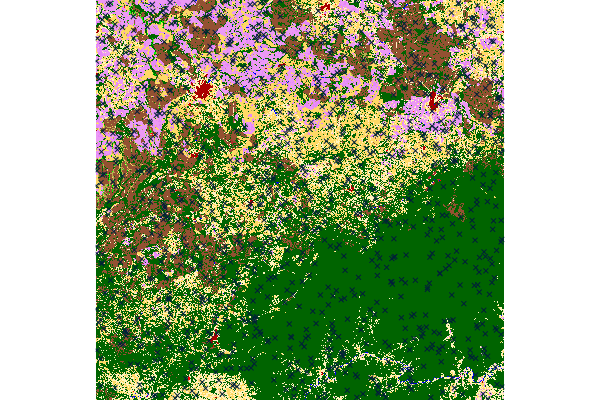

In [104]:
# mostrar mapas
rast = 'mbiomas'
img = gj.GrassRenderer()
img.run('d.rast', map=rast) 
img.run('d.vect', map=train_points)
img.show()

In [77]:
# setup for train and predict on 1999 image - random points
group = 'l7c2_rf'
model = f'{datadir}rf_model_mbiomas_points.gz'
outml = f'{l7c2}_mapbiomas_RF_points'
img_list = [f'{l7c2}_SR_B.{band}' for band in [1,2,3,4,5,7]]

In [78]:
grass.run_command('i.group', group=group, subgroup=group, input=img_list, overwrite=True)

In [79]:
%%time
# train on 1999 image
grass.run_command('r.learn.train', group=group, training_points=train_points, field='mbiomas', 
                  model_name='RandomForestClassifier', n_estimators=500, save_model=model, overwrite=True)

CPU times: user 2.5 ms, sys: 8.25 ms, total: 10.8 ms
Wall time: 2.95 s


In [80]:
# predict on 1999 image - based on random points
grass.run_command('r.learn.predict', group=group, load_model=model, output=outml, overwrite=True);

In [81]:
# colors
grass.write_command('r.colors', map=outml, rules='-', stdin=colr_mbiom);

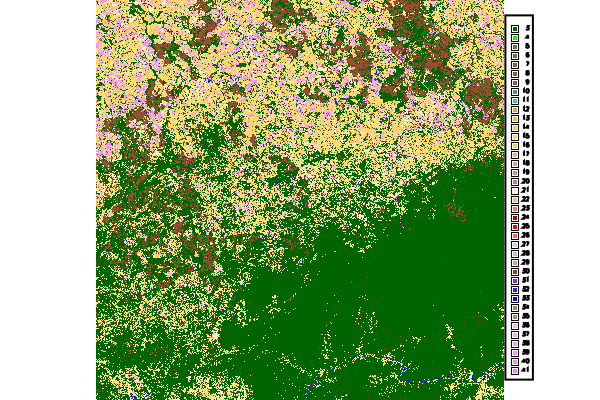

In [82]:
# display
rast = outml
img = gj.GrassRenderer()
img.run('d.rast', map=rast) 
img.run('d.legend',raster=rast, at=(5, 95, 85, 90), flags="b")
img.show()

In [83]:
# kappa
out_kappa = f'{datadir}kappa_1999_points.txt'
reference = mbiomas
classfied = outml
grass.run_command('r.kappa', classification=classfied, reference=reference, 
                       output=out_kappa, flags='w', overwrite=True)

#### testar com polígonos de treinamento

In [60]:
# grass.run_command('r.out.gdal', input=mbiomas, output=f'{datadir}mapbiomas_region.tif')

In [61]:
mb_poly = 'mbiomas_petar'

In [9]:
# import polygon
grass.run_command('v.in.ogr', input=f'{datadir}{mb_poly}.gpkg', output=mb_poly, overwrite=True)

# convert to raster
grass.run_command('v.to.rast', input=mb_poly, output=mb_poly, use='attr', attribute_column='class', overwrite=True)

In [36]:
# colors
grass.write_command('r.colors', map=mb_poly, rules='-', stdin=colr_mbiom);

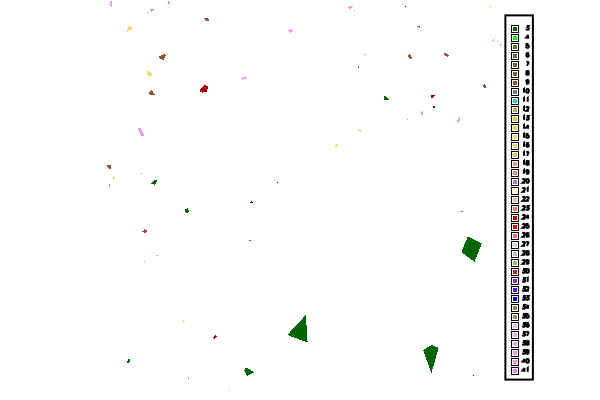

In [62]:
# display
rast = mb_poly
img = gj.GrassRenderer()
img.run('d.rast', map=rast) 
img.run('d.legend',raster=rast, at=(5, 95, 85, 90), flags="b")
img.show()

In [84]:
# setup for train and predict on 1999 image - random points
group = 'l7c2_rf'
model = f'{datadir}rf_model_mbiomas_poly.gz'
outml = f'{l7c2}_mapbiomas_RF_polys'
img_list = [f'{l7c2}_SR_B.{band}' for band in [1,2,3,4,5,7]]

In [85]:
grass.run_command('i.group', group=group, subgroup=group, input=img_list, overwrite=True)

In [86]:
%%time
# train on 1999 image - with polygons
grass.run_command('r.learn.train', group=group, training_map=mb_poly, 
                  model_name='RandomForestClassifier', n_estimators=500, save_model=model, overwrite=True)

CPU times: user 3.05 ms, sys: 5.03 ms, total: 8.08 ms
Wall time: 21.2 s


In [87]:
%%time
# predict on 1999 image - based on polygons
grass.run_command('r.learn.predict', group=group, load_model=model, output=outml, overwrite=True);

CPU times: user 10.1 ms, sys: 15.4 ms, total: 25.5 ms
Wall time: 4min 58s


In [88]:
# colors
grass.write_command('r.colors', map=outml, rules='-', stdin=colr_mbiom);

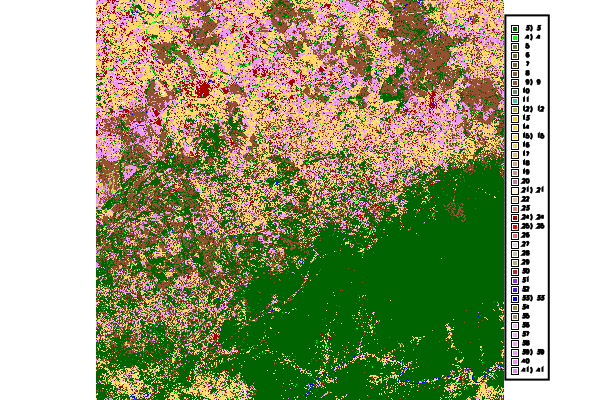

In [89]:
# display
rast = outml
img = gj.GrassRenderer()
img.run('d.rast', map=rast) 
img.run('d.legend',raster=rast, at=(5, 95, 85, 90), flags="b")
img.show()

In [90]:
# kappa
out_kappa = f'{datadir}kappa_1999_polys.txt'
reference = mbiomas
classfied = outml
grass.run_command('r.kappa', classification=classfied, reference=reference, 
                       output=out_kappa, flags='w', overwrite=True)

In [71]:
cols = ['Cats','Comission','Omission','Estimated Kappa']

kpoint = [[3,16.943783,9.813357,0.648036],
[4,94.475138,99.934219,0.053839],
[9,31.711044,53.587363,0.636219],
[12,88.208617,99.790570,0.111429],
[15,55.359480,42.392906,0.356711],
[21,72.374840,71.797941,0.192429],
[24,90.308609,99.534908,0.093496],
[33,30.450439,47.901188,0.694864],
[39,69.986538,73.578016,0.257013],
[41,84.291326,95.308284,0.125390]]


kpoly = [[3,7.325900,22.976535,0.847823],
[4,97.276836,84.502039,0.025781],
[9,56.138263,37.107779,0.355996],
[12,92.116159,81.109709,0.072066],
[15,55.323541,46.599928,0.357129],
[21,70.838170,94.901890,0.209576],
[24,91.595489,24.169200,0.080578],
[25,86.328656,94.421869,0.136255],
[33,50.324396,28.981118,0.495712],
[39,80.903204,59.442838,0.141120],
[41,79.008858,92.004564,0.180201]]

In [72]:
pd_pt = pd.DataFrame(kpoint,columns=cols)

In [73]:
pd_pt 

,Cats,Comission,Omission,Estimated Kappa
0,3,16.943783,9.813357,0.648036
1,4,94.475138,99.934219,0.053839
2,9,31.711044,53.587363,0.636219
3,12,88.208617,99.790570,0.111429
4,15,55.359480,42.392906,0.356711
5,21,72.374840,71.797941,0.192429
6,24,90.308609,99.534908,0.093496
7,33,30.450439,47.901188,0.694864
8,39,69.986538,73.578016,0.257013
9,41,84.291326,95.308284,0.125390


In [74]:
pd_pl = pd.DataFrame(kpoly,columns=cols)

In [75]:
pd_pl

,Cats,Comission,Omission,Estimated Kappa
0,3,7.325900,22.976535,0.847823
1,4,97.276836,84.502039,0.025781
2,9,56.138263,37.107779,0.355996
3,12,92.116159,81.109709,0.072066
4,15,55.323541,46.599928,0.357129
5,21,70.838170,94.901890,0.209576
6,24,91.595489,24.169200,0.080578
7,25,86.328656,94.421869,0.136255
8,33,50.324396,28.981118,0.495712
9,39,80.903204,59.442838,0.141120


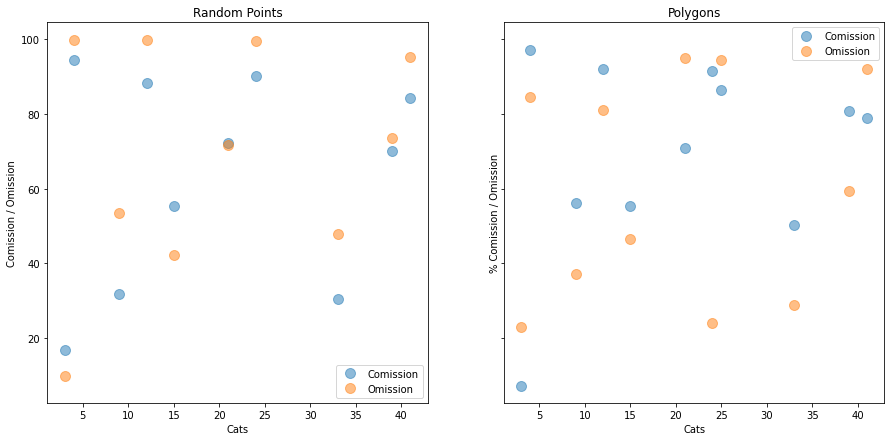

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,7))

ax1.plot(pd_pt['Cats'], pd_pt['Comission'],'o', ms=10, alpha=0.5, label='Comission')
ax1.plot(pd_pt['Cats'], pd_pt['Omission'],'o', ms=10, alpha=0.5, label='Omission')
ax1.set_title('Random Points')
ax1.set_xlabel('Cats')
ax1.set_ylabel('Comission / Omission')
ax1.legend()

ax2.plot(pd_pl['Cats'], pd_pl['Comission'],'o', ms=10, alpha=0.5, label='Comission')
ax2.plot(pd_pl['Cats'], pd_pl['Omission'],'o', ms=10, alpha=0.5, label='Omission')
ax2.set_title('Polygons')
ax2.set_xlabel('Cats')
ax2.set_ylabel('% Comission / Omission')
ax2.legend()

Text(0, 0.5, 'Polygons')

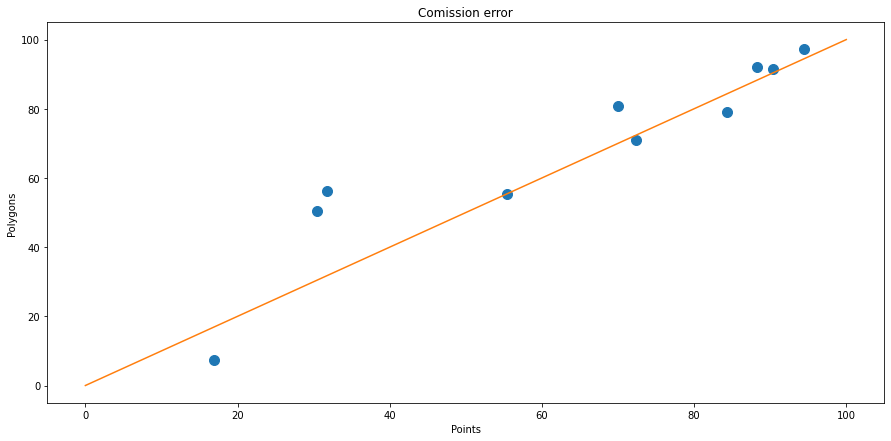

In [119]:
col = 'Comission'
plt.figure(figsize=(15,7))
plt.plot(pd_pt[col],pd_pl[col].drop(index=7),'o', ms=10)
plt.plot([0,100],[0,100])
plt.title(f'{col} error')
plt.xlabel('Points')
plt.ylabel('Polygons')

Text(0, 0.5, 'Polygons')

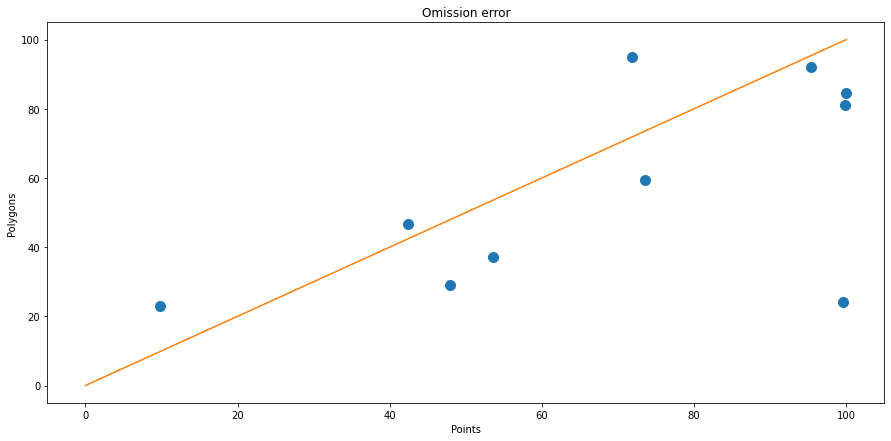

In [118]:
col = 'Omission'
plt.figure(figsize=(15,7))
plt.plot(pd_pt[col],pd_pl[col].drop(index=7),'o', ms=10)
plt.plot([0,100],[0,100])
plt.title(f'{col} error')
plt.xlabel('Points')
plt.ylabel('Polygons')

In [113]:
# 2019 image
g_sg = 'l8c2_rf'
img_list = [f'{l8c2}_SR_B.{band}' for band in [2,3,4,5,6,7]]
grass.run_command('i.group', group=g_sg, subgroup=g_sg, input=img_list, overwrite=True)

In [115]:
%%time
# predict on 2019 image
out_rf_2019 = f'{l8c2}_mapbiomas_RF'
grass.run_command('r.learn.predict', group=g_sg, load_model=sav_model, output=out_rf_2019, overwrite=True);

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.53 µs


In [116]:
# colors
grass.write_command('r.colors', map=out_rf, rules='-', stdin=colr_mbiom);

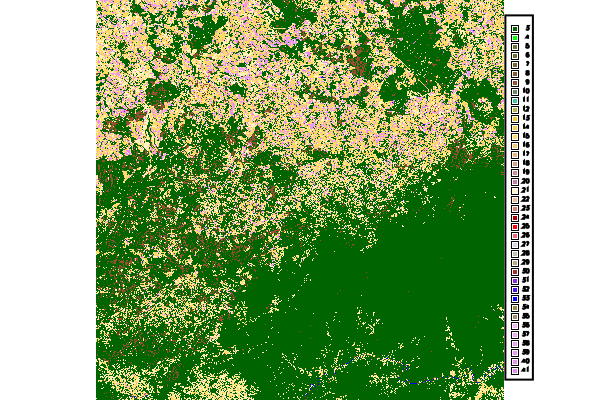

In [117]:
# display
rast = out_rf_2019
img = gj.GrassRenderer()
img.run('d.rast', map=rast) 
img.run('d.legend',raster=rast, at=(5, 95, 85, 90), flags="b")
img.show()

In [172]:
grass.run_command('r.kappa', classification=out_rf_2019, reference=mbiomas, 
                       output=f'{datadir}kappa_2019.txt', flags='w', overwrite=True)

In [ ]:
# Cats	% Comission	% Omission	Estimated Kappa
# 3		23.994687	7.934848	0.501576
# 4		NA			NA			NA
# 9		50.034856	81.553239	0.426014
# 12	97.802198	99.989260	0.014788
# 15	57.816655	51.777259	0.328158
# 20	NA			NA			NA
# 21	74.289988	73.216280	0.171058
# 24	79.547063	99.249526	0.201517
# 25	NA			NA			NA
# 30	NA			NA			NA
# 33	25.818809	63.342956	0.741276
# 36	NA			NA			NA
# 39	76.451656	84.116159	0.188378
# 41	86.275933	93.713722	0.104798

# Kappa		Kappa Variance
# 0.380266	

In [153]:
# generate random validation points
npts = 2000
valid_points = 'pts_mapbiomas_valid'
grass.run_command('v.random', output=valid_points, npoints=npts, overwrite=True)
grass.run_command('v.db.addtable', map=valid_points, columns='mbiomas int, pred_1999 int, pred_2019 int', overwrite=True)
grass.run_command('v.what.rast', map=valid_points, raster=mbiomas, column='mbiomas', overwrite=True)
grass.run_command('v.what.rast', map=valid_points, raster=out_rf_1999, column='pred_1999', overwrite=True)
grass.run_command('v.what.rast', map=valid_points, raster=out_rf_2019, column='pred_2019', overwrite=True)


In [154]:
sqlpath = grass.read_command("db.databases", driver="sqlite").replace('\n', '')
con = sqlite3.connect(sqlpath)
sqlstat=f'SELECT * FROM {valid_points}'
df = pd.read_sql_query(sqlstat, con)
con.close()

Text(0, 0.5, 'pred_2019')

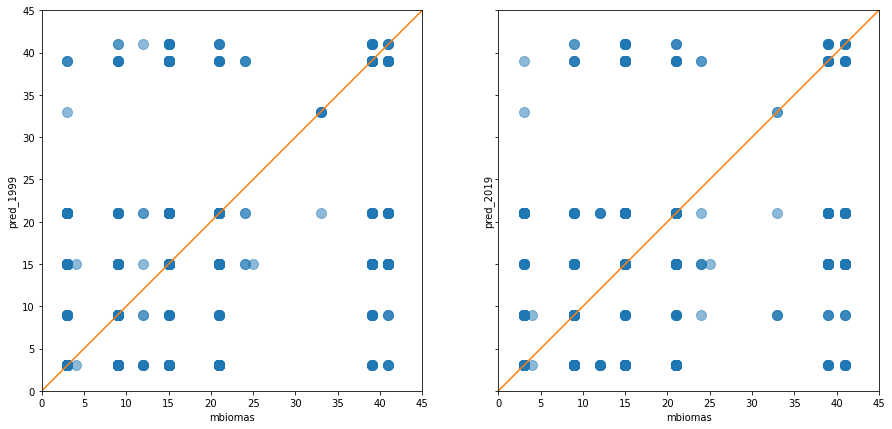

In [160]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,7))
lims = (0,45)

ax1.plot(df['mbiomas'],df['pred_1999'],'o', ms=10, alpha=0.5)
ax1.plot([-10,50],[-10,50])
ax1.set_xlim(lims)
ax1.set_ylim(lims)
ax1.set_xlabel('mbiomas')
ax1.set_ylabel('pred_1999')

ax2.plot(df['mbiomas'],df['pred_2019'],'o', ms=10, alpha=0.5)
ax2.plot([-10,50],[-10,50])
ax2.set_xlim(lims)
ax2.set_ylim(lims)
ax2.set_xlabel('mbiomas')
ax2.set_ylabel('pred_2019')
